In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## **Import tensorflow libraries**
---

In [2]:
import tensorflow as tf
import tensorflow.keras.backend as K
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model

import os
import numpy as np
from numpy.random import randn
from PIL import Image
from IPython.display import display

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

## **Test Model**
---

In [11]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

def display_image_arr(image_arr):
  img_array = (image_arr * 127.5) + 127.5
  img = Image.fromarray(img_array.astype(np.uint8), 'RGB')
  display(img)
 
# load model
generator = load_model('/content/gdrive/My Drive/iss/prpm/pureGAN/zalando-wbg_asy_deep_generator_1049.h5')
# model.summary()

Testing by manual inspection

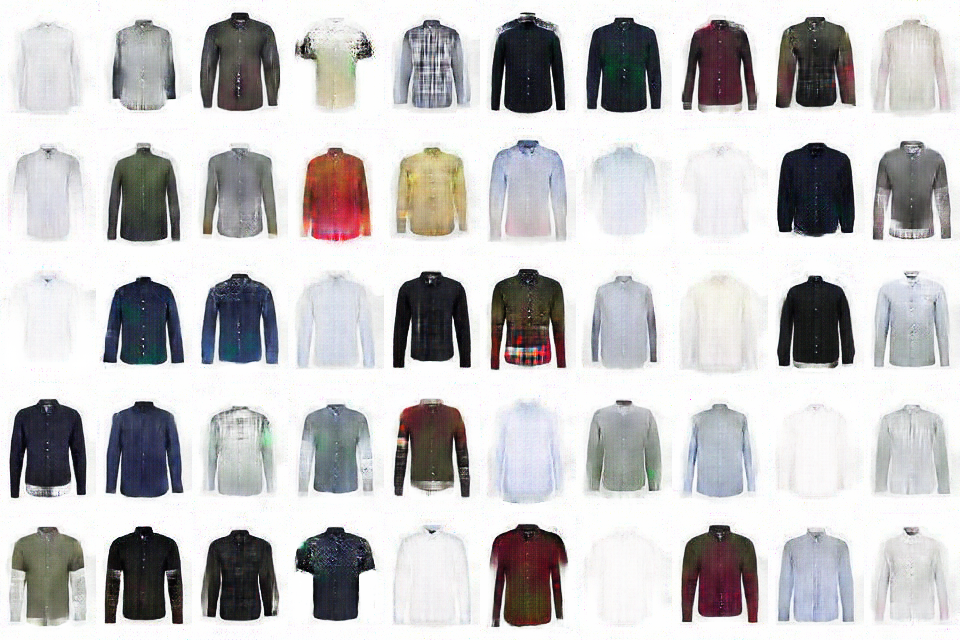

In [12]:
def put_img_in_grid(generator, gridsize=(5,10), single_img_shape=(128, 96, 3)):
  # final = np.empty((single_img_shape[0], single_img_shape[1]*dim, single_img_shape[2]))
  for row in range(gridsize[0]):
    # row_img = np.empty(single_img_shape)
    for col in range(gridsize[1]):
      latent_points = generate_latent_points(generator.layers[0].input.shape[1], 1)
      img = generator.predict(latent_points)[0]
      row_img = img if col==0 else np.concatenate((row_img, img), axis=1)
    final = row_img if row==0 else np.concatenate((final, row_img), axis=0)
  return final

image = put_img_in_grid(generator)
display_image_arr(image)

In [ ]:
# generate images
latent_points = generate_latent_points(generator.layers[0].input.shape[1], 9)
X = generator.predict(latent_points)
# plot the result
# show_plot(X, 1)
for i in range(X.shape[0]):
  x_half1 = X[i,:,0:int(X.shape[2]/2),:]
  x_half2 = X[i,:,int(X.shape[2]/2):X.shape[2]-1,:]
  x_symmetric1 = np.concatenate((x_half1,np.flip(x_half1,axis=1)),axis=1)
  x_symmetric2 = np.concatenate((np.flip(x_half2,axis=1),x_half2),axis=1)
  x = np.concatenate((x_symmetric1, x_symmetric2),axis=1)
  display_image_arr(x)

Testing by VGG16 model pretrained w/ ImageNet data

In [ ]:
vgg16 = VGG16()

# classes in imagenet associated to clothes
clothes_class = ["academic_gown","apron","bikini","brassiere","breastplate",
                 "bulletproof_vest","cardigan","Cardigan","chain_mail","cloak",
                 "cuirass","fur_coat","hoopskirt","gown","jersey","kimono","lab_coat",
                 "military_uniform","miniskirt","overskirt","pajama","poncho"
                 "sarong","suit","sweatshirt","vestment","trench_coat"]

553467904/553467096 [==============================] - 9s 0us/step


In [ ]:
def get_generator_files(drive_folderid):
  # Auto-iterate using the query syntax https://developers.google.com/drive/v2/web/search-parameters
  file_list = drive.ListFile({'q': "'" + drive_folderid + "' in parents"}).GetList()
  generator_files = []
  for f in file_list:
    # if "generator" in  f['title'] and '.h5' in f['title']:
    if 'zalando-wms-wgb_asy_deep_generator' in f['title']:
      generator_files.append(f['title'])
  return generator_files

def make_square(im, min_size=256, fill_color=(255, 255, 255)):
    x, y = im.size
    factor = min(min_size/x, min_size/y)
    im = im.resize((int(x*factor), int(y*factor)))
    size = max(min_size, x, y)
    new_im = Image.new('RGB', (size, size), fill_color)
    new_im.paste(im, (int((size - x) / 2), int((size - y) / 2)))
    return new_im

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
generator_files = get_generator_files("1goYsUjl7ZGpxZXAscAebi29Akh9sULoa")
probabilities = []
for fn in range(len(generator_files)):
  try:
    generator = load_model('/content/gdrive/My Drive/iss/prpm/pureGAN/' + generator_files[fn])
    success = 0
    nbr_samples = 1000
    for i in range(nbr_samples):
      # Prep image for prediction
      latent_pts = generate_latent_points(generator.layers[0].input.shape[1],1)
      img_array = generator.predict(latent_pts)[0]
      img_array = (img_array * 127.5) + 127.5
      img = Image.fromarray(img_array.astype(np.uint8), 'RGB')
      img = make_square(img, 224)
      img_array = np.array(img)
      image = img_array.reshape((1, img_array.shape[0], img_array.shape[1], img_array.shape[2]))
      image = preprocess_input(image) # prepare the image for the VGG model

      # predict the probability across all output classes
      yhat = vgg16.predict(image)
      label = decode_predictions(yhat,top=1000)
      # for j in range(len(label[0])):
      #   print(label[0][j])
      label = label[0][0] # retrieve the most likely result, e.g. highest probability
      # print('%d %s (%.2f%%)' % (i, label[1], label[2]*100))
      if label[1] in clothes_class: success = success + 1
    success_prob = success / nbr_samples
    probabilities.append(generator_files[fn] + ',' + str(success_prob))
    print(generator_files[fn] + ',' + str(success_prob))
  except:
    probabilities.append(generator_files[fn] + ',file_not_found')
    print(generator_files[fn] + ',file_not_found')

40960/35363 [==================================] - 0s 0us/step
zalando-wms-wgb_asy_deep_generator_1599.h5,0.149
zalando-wms-wgb_asy_deep_generator_1449.h5,0.159
zalando-wms-wgb_asy_deep_generator_best.h5,0.16
zalando-wms-wgb_asy_deep_generator_1299.h5,0.14
zalando-wms-wgb_asy_deep_generator_1149.h5,0.123
zalando-wms-wgb_asy_deep_generator_999.h5,0.132
zalando-wms-wgb_asy_deep_generator_899.h5,0.13
zalando-wms-wgb_asy_deep_generator_749.h5,0.137
zalando-wms-wgb_asy_deep_generator_599.h5,file_not_found
zalando-wms-wgb_asy_deep_generator_449.h5,file_not_found
zalando-wms-wgb_asy_deep_generator_299.h5,file_not_found
zalando-wms-wgb_asy_deep_generator_149.h5,file_not_found
zalando-wms-wgb_asy_deep_generator_best.h5,0.172


## **Convert .h5 to .tflite to save space**
---

In [ ]:
model = load_model('/content/gdrive/My Drive/iss/prpm/pureGAN/zalando-wbg_asy_deep_generator_1049.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()
file = open('zalando-wbg_asy_deep_generator_1049.tflite' , 'wb') 
file.write( tflite_model )

INFO:tensorflow:Assets written to: /tmp/tmp1_1mwjdm/assets


INFO:tensorflow:Assets written to: /tmp/tmp1_1mwjdm/assets


5735152

Doing prediction with tflite models

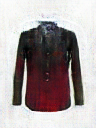

In [ ]:
# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path='zalando_asy_generator_best1.tflite')
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

for i in range(1):
  # Test the model on random input data.
  input_shape = input_details[0]['shape']
  input_data = generate_latent_points(200, 1).astype(np.float32) 
  interpreter.set_tensor(input_details[0]['index'], input_data)

  interpreter.invoke()

  # The function `get_tensor()` returns a copy of the tensor data.
  # Use `tensor()` in order to get a pointer to the tensor.
  output_data = interpreter.get_tensor(output_details[0]['index'])
  display_image_arr(output_data[0])
